In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
torch.__version__


'2.3.0+cu121'

# visualisation

## 1. DATA (preparing data and loading data)
* excel spreadsheet
* images

In [2]:
# lets create *known * parameter
X = torch.arange(0, 10, 0.2).unsqueeze(dim=1)#dim=1 is to make it 2D an column vector
Y= 2*X + 1 + 0.1
len(X), len(Y)

(50, 50)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)#random_state is to make the split radnomly deterministic 
len(X_train), len(X_test),len(Y_train), len(Y_test)

(40, 10, 40, 10)

In [4]:
X_train

tensor([[2.4000],
        [0.8000],
        [7.4000],
        [1.6000],
        [0.6000],
        [1.2000],
        [8.2000],
        [9.2000],
        [9.4000],
        [3.0000],
        [1.8000],
        [3.2000],
        [4.8000],
        [6.8000],
        [6.2000],
        [0.0000],
        [8.8000],
        [5.4000],
        [6.6000],
        [1.0000],
        [5.8000],
        [2.2000],
        [7.2000],
        [0.2000],
        [4.2000],
        [0.4000],
        [8.6000],
        [7.0000],
        [4.6000],
        [8.0000],
        [2.0000],
        [4.4000],
        [3.6000],
        [9.8000],
        [4.0000],
        [1.4000],
        [8.4000],
        [2.8000],
        [5.6000],
        [7.6000]])

In [5]:
def plot_pridictions(train_data=X_train, train_labels=Y_train, test_data=X_test, test_labels=Y_test, pred=None):
    
    plt.figure(figsize=(12, 6))
    plt.scatter(train_data, train_labels, c='b', label='Train data')
    plt.scatter(test_data, test_labels, c='g', label='Test data')
    if pred is not None:
        plt.scatter(test_data, pred, c='r', label='Predictions')#
    plt.legend()
    plt.show()
    
    

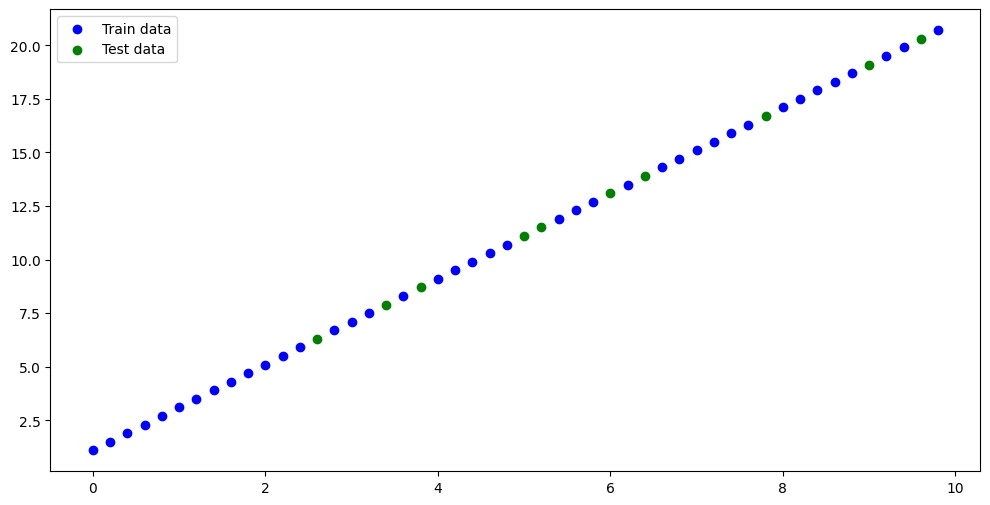

In [6]:
plot_pridictions()

# 1st pytorch model

In [7]:
# Create a model class
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)
            

### PyTorch model building essentials

PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

They are [`torch.nn`](https://pytorch.org/docs/stable/nn.html), [`torch.optim`](https://pytorch.org/docs/stable/optim.html), [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html). For now, we'll focus on the first two and get to the other two later (though you may be able to guess what they do).

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way). |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via [**gradient descent**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html))  are calculated automatically, this is often referred to as "autograd".  | 
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented. | 
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). | 
| `def forward()` | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above). |

If the above sounds complex, think of like this, almost everything in a PyTorch neural network comes from `torch.nn`,
* `nn.Module` contains the larger building blocks (layers)
* `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make `nn.Module`(s))
* `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within  `nn.Module`(s)
* `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data 

![a pytorch linear model with annotations](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-model-annotated.png)
*Basic building blocks of creating a PyTorch model by subclassing `nn.Module`. For objects that subclass `nn.Module`, the `forward()` method must be defined.*

> **Resource:** See more of these essential modules and their uses cases in the [PyTorch Cheat Sheet](https://pytorch.org/tutorials/beginner/ptcheat.html). 


In [8]:
 
# random seed for reproducibility
torch.manual_seed(42)# 42 is universal random seed because of Hitchhiker's Guide to the Galaxy
# instance of the model
model_01 = LinearRegressionModel()
model_01.weights, model_01.bias#1st random weights and bias

(Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True))

In [9]:
#list of named parameter of model
print(list(model_01.named_parameters()))
#in dictionary
model_01.state_dict()

[('weights', Parameter containing:
tensor([0.3367], requires_grad=True)), ('bias', Parameter containing:
tensor([0.1288], requires_grad=True))]


OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()` 
To check this we can pass it the test data `X_test` to see how closely it predicts `y_test`.

When we pass data to our model, it'll go through the model's `forward()` method and produce a result using the computation we've defined. 

Let's make some predictions. 

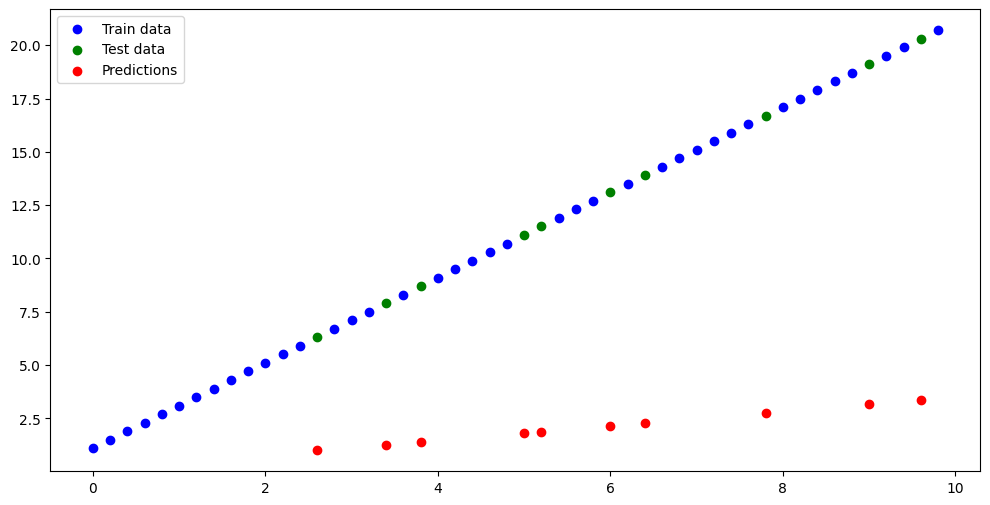

In [10]:
# pridiction wit model
with torch.inference_mode():#inference mode is to disable gradient computation
    Y_pred = model_01(X_test)
    plot_pridictions(pred=Y_pred.detach().numpy())#detach() is to detach the tensor from the computation graph


##

# train the model



## loss function and optimizer
| Function | What does it do? | Where does it live in PyTorch? | Common values |
| ----- | ----- | ----- | ----- |
| **Loss function** | Measures how wrong your models predictions (e.g. `y_preds`) are compared to the truth labels (e.g. `y_test`). Lower the better. | PyTorch has plenty of built-in loss functions in [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions). | Mean absolute error (MAE) for regression problems ([`torch.nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)). Binary cross entropy for binary classification problems ([`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)).  |
| **Optimizer** | Tells your model how to update its internal parameters to best lower the loss. | You can find various optimization function implementations in [`torch.optim`](https://pytorch.org/docs/stable/optim.html). | Stochastic gradient descent ([`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)). Adam optimizer ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)). | 

[more about loss fxn](https://pytorch.org/docs/stable/nn.html#loss-functions)

[more abbout optim](https://pytorch.org/docs/stable/optim.html)

In [11]:
# loss function in pytorch
loss_fn = nn.L1Loss()#Mean Squared Error Loss

# optimizer in pytorch
optimizer = optim.SGD(model_01.parameters(), #Stochastic Gradient Descent optimizer
                    lr=0.001) # <- learning rate (how much precise optimizator changes the weights and bias)
                                                    

lr = 0.001

('weights', Parameter containing:
tensor([0.3367]`changes the 3367 by 0.001`, requires_grad=True)), ('bias', 

`same for bias`

## building traing loop in pytorch

As for the testing loop (evaluating our model), the typical steps include:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_test)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_test)` | 
| 3 | Calulate evaluation metrics (optional) | Alongisde the loss value you may want to calculate other evaluation metrics such as accuracy on the test set. | Custom functions |

Notice the testing loop doesn't contain performing backpropagation (`loss.backward()`) or stepping the optimizer (`optimizer.step()`), this is because no parameters in the model are being changed during testing, they've already been calculated. For testing, we're only interested in the output of the forward pass through the model.

![pytorch annotated testing loop](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-testing-loop-annotated.png)

Let's put all of the above together and train our model for 100 **epochs** (forward passes through the data) and we'll evaluate it every 10 epochs.


Epoch: 0,loss=8.713896751403809, Test Loss: 10.723081588745117
Epoch: 1,loss=8.691228866577148, Test Loss: 10.694708824157715
Epoch: 2,loss=8.668558120727539, Test Loss: 10.666337013244629
Epoch: 3,loss=8.645890235900879, Test Loss: 10.637965202331543
Epoch: 4,loss=8.623220443725586, Test Loss: 10.609594345092773
Epoch: 5,loss=8.600552558898926, Test Loss: 10.58122444152832
Epoch: 6,loss=8.577882766723633, Test Loss: 10.552851676940918
Epoch: 7,loss=8.555213928222656, Test Loss: 10.524480819702148
Epoch: 8,loss=8.53254508972168, Test Loss: 10.496109008789062
Epoch: 9,loss=8.509875297546387, Test Loss: 10.467737197875977
Epoch: 10,loss=8.48720645904541, Test Loss: 10.43936538696289
Epoch: 11,loss=8.464537620544434, Test Loss: 10.410995483398438
Epoch: 12,loss=8.441868782043457, Test Loss: 10.382623672485352
Epoch: 13,loss=8.41919994354248, Test Loss: 10.354251861572266
Epoch: 14,loss=8.396531105041504, Test Loss: 10.32588005065918
Epoch: 15,loss=8.373861312866211, Test Loss: 10.29750823

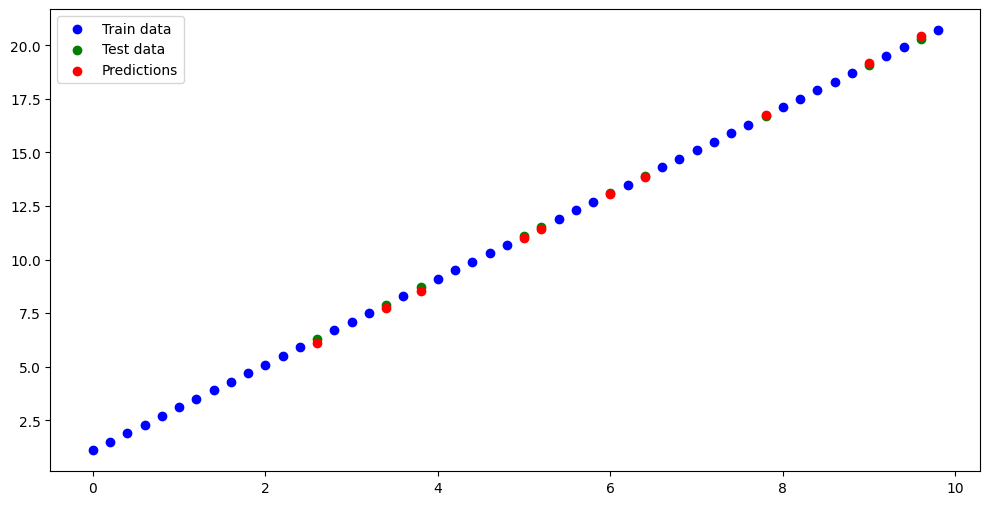

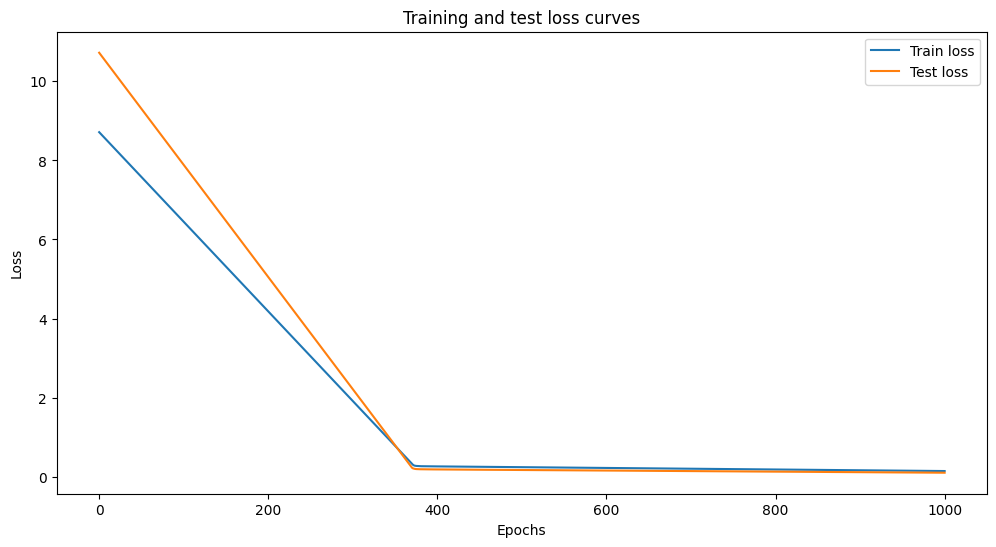

In [12]:
torch.manual_seed(42)# 42 is universal random seed because of Hitchhiker's Guide to the Galaxy
# epoch is the number of times the model will see the entire dataset
epochs = 1001
epoch_loss = []# to store the loss
epoch_test_loss = []# to store the test loss
epoch_count = []# to store the epoch number
# training loop

for epoch in range(epochs):
    #set the model to training mode
    model_01.train()# training mode is to enable gradient computation
    """" 
        model_01.eval()# evaluation mode is to disable gradient computation
    """
    # forward pass
    Y_pred = model_01(X_train)
    loss = loss_fn(Y_pred, Y_train)
    
    # backward pass
    optimizer.zero_grad() # <- reset the gradients to 0
    loss.backward() # <- compute the gradients for each parameter
    optimizer.step() # <- update the weights and bias
    #testing
    model_01.eval()# evaluation mode is to disable gradient computation
    
    # print some information
    # print(f'Epoch: {epoch}, Loss: {loss}')
    ## testing the model
    if epoch % 1 == 0: 
        epoch_count.append(epoch)
        with torch.inference_mode():#to disable gradient computation
            test_pred = model_01(X_test)
            test_loss = loss_fn(test_pred, Y_test)
            epoch_loss.append(loss.item())
            epoch_test_loss.append(test_loss.item())#item() is to get the value of tensor  
            print(f'Epoch: {epoch},loss={loss}, Test Loss: {test_loss.item()}')

    """if epoch % 10000 == 0:

        with torch.inference_mode():

            # Plot the loss curves
            plt.figure(figsize=(120, 60))
            plt.plot(epoch_count, epoch_loss, label="Train loss")
            plt.plot(epoch_count, epoch_test_loss, label="Test loss")
            plt.title("Training and test loss curves")
            plt.ylabel("Loss")
            plt.xlabel("Epochs")
            plt.legend();
        epoch_loss = []# to store the loss
        epoch_test_loss = []# to store the test loss
        epoch_count = []# to store the epoch number"""
Y_pred_new = model_01(X_test)
plot_pridictions(pred=Y_pred_new.detach().numpy())
def plot_loss(epoch_count, epoch_loss, epoch_test_loss):
    plt.figure(figsize=(12, 6))
    plt.plot(epoch_count, epoch_loss, label="Train loss")
    plt.plot(epoch_count, epoch_test_loss, label="Test loss")
    plt.title("Training and test loss curves")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend();
    plt.show()
plot_loss(epoch_count, epoch_loss, epoch_test_loss)


In [13]:
model_01.state_dict()

OrderedDict([('weights', tensor([2.0458])), ('bias', tensor([0.7783]))])

# save a model

If you've trained a PyTorch model, chances are you'll want to save it and export it somewhere.

As in, you might train it on Google Colab or your local machine with a GPU but you'd like to now export it to some sort of application where others can use it. 

Or maybe you'd like to save your progress on a model and come back and load it back later.

For saving and loading models in PyTorch, there are three main methods you should be aware of (all of below have been taken from the [PyTorch saving and loading models guide](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference)):

| PyTorch method | What does it do? | 
| ----- | ----- |
| [`torch.save`](https://pytorch.org/docs/stable/torch.html?highlight=save#torch.save) | Saves a serialized object to disk using Python's [`pickle`](https://docs.python.org/3/library/pickle.html) utility. Models, tensors and various other Python objects like dictionaries can be saved using `torch.save`.  | 
| [`torch.load`](https://pytorch.org/docs/stable/torch.html?highlight=torch%20load#torch.load) | Uses `pickle`'s unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc). |
| [`torch.nn.Module.load_state_dict`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=load_state_dict#torch.nn.Module.load_state_dict)| Loads a model's parameter dictionary (`model.state_dict()`) using a saved `state_dict()` object. | 

> **Note:** As stated in [Python's `pickle` documentation](https://docs.python.org/3/library/pickle.html), the `pickle` module **is not secure**. That means you should only ever unpickle (load) data you trust. That goes for loading PyTorch models as well. Only ever use saved PyTorch models from sources you trust.


In [14]:
# save the model
from pathlib import Path

# create directory
model_path = Path('models')
model_path.mkdir(exist_ok=True,parents=True)

model_name = 'model_01_workflow.pth'#.pth is pytorch model extension

torch.save(model_01.state_dict(), model_path / model_name)
print(f'Model saved at {model_path / model_name}')

Model saved at models/model_01_workflow.pth


In [15]:
model_01.state_dict()

OrderedDict([('weights', tensor([2.0458])), ('bias', tensor([0.7783]))])

### bringing model back or loading 
And just to make sure everything worked well, let's load it back in.

We'll:
* Create a new instance of the `LinearRegressionModel()` class
* Load in the model state dict using `torch.nn.Module.load_state_dict()`
* Send the new instance of the model to the target device (to ensure our code is device-agnostic)

In [16]:
loaded_model_01 = LinearRegressionModel()#instance of model

#load the model
loaded_model_01.load_state_dict(torch.load(model_path / model_name))
loaded_model_01.state_dict()

OrderedDict([('weights', tensor([2.0458])), ('bias', tensor([0.7783]))])

In [17]:
#setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
device

'cuda'

# linear model 

In [19]:
# linear model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer= nn.Linear(1,1)#1 input and 1 output

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1,model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

## training the model 2 

In [20]:
# setting thr device to cuda
#put data also to device
model_1.to(device)

X_train=X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)
X_train.device, Y_train.device,model_1.state_dict()

(device(type='cuda', index=0),
 device(type='cuda', index=0),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
              ('linear_layer.bias', tensor([0.8300], device='cuda:0'))]))

In [22]:
# training loop
# random seed for reproducibility
torch.manual_seed(42)
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.001)#
epochs = 1001
epoch_loss = [] 
epoch_test_loss = []
epoch_count = []
for epoch in range(epochs):
    model_1.train()
    # forward pass
    Y_pred = model_1(X_train)
    # loss
    loss = loss_fn(Y_pred, Y_train)#training loss
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # testing
    model_1.eval()
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        with torch.inference_mode():
            test_pred = model_1(X_test)#testing loss
            test_loss = loss_fn(test_pred, Y_test)
            epoch_loss.append(loss.item())
            epoch_test_loss.append(test_loss.item())
            print(f'Epoch: {epoch},loss={loss}, Test Loss: {test_loss.item()}')    

Epoch: 0,loss=5.998396396636963, Test Loss: 7.477763652801514
Epoch: 10,loss=5.771706581115723, Test Loss: 7.19404935836792
Epoch: 20,loss=5.545016288757324, Test Loss: 6.910335063934326
Epoch: 30,loss=5.318325996398926, Test Loss: 6.626621246337891
Epoch: 40,loss=5.091635704040527, Test Loss: 6.342906951904297
Epoch: 50,loss=4.864944934844971, Test Loss: 6.059193134307861
Epoch: 60,loss=4.6382551193237305, Test Loss: 5.775478839874268
Epoch: 70,loss=4.411564350128174, Test Loss: 5.491765022277832
Epoch: 80,loss=4.184874057769775, Test Loss: 5.208050727844238
Epoch: 90,loss=3.958184003829956, Test Loss: 4.9243364334106445
Epoch: 100,loss=3.7314934730529785, Test Loss: 4.640622615814209
Epoch: 110,loss=3.504803419113159, Test Loss: 4.356908321380615
Epoch: 120,loss=3.2781131267547607, Test Loss: 4.0731940269470215
Epoch: 130,loss=3.0514228343963623, Test Loss: 3.789479970932007
Epoch: 140,loss=2.824732542037964, Test Loss: 3.505765914916992
Epoch: 150,loss=2.5980422496795654, Test Loss:

In [ ]:
model_01.state_dict()

OrderedDict([('weights', tensor([2.0458])), ('bias', tensor([0.7783]))])

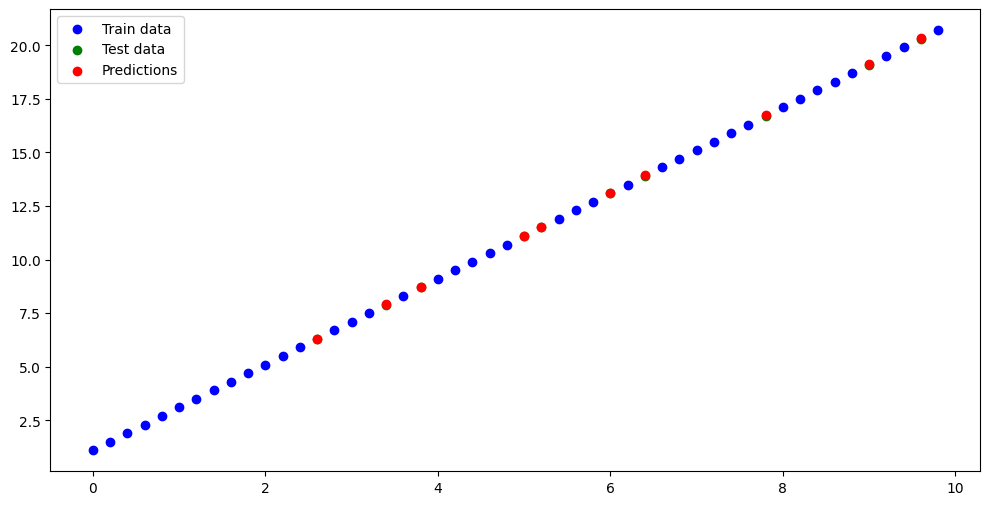

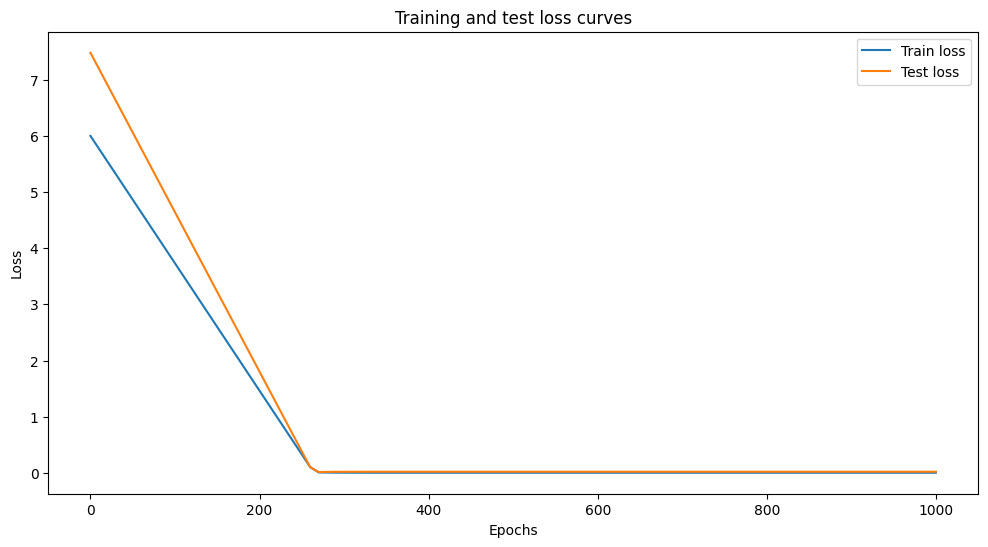

In [30]:
plot_pridictions(pred=(model_1(X_test)).cpu().detach().numpy())
plot_loss(epoch_count, epoch_loss, epoch_test_loss)# list is always in cpu

In [34]:
# saving the model
model_name = 'model_1_workflow_v2.pth'
torch.save(model_1.state_dict(), model_path / model_name)
print(f'Model saved at {model_path / model_name}')
model_1.state_dict()

Model saved at models/model_1_workflow_v2.pth


OrderedDict([('linear_layer.weight', tensor([[2.0038]], device='cuda:0')),
             ('linear_layer.bias', tensor([1.1000], device='cuda:0'))])

In [33]:
#loading the model
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(model_path / model_name))
loaded_model_1.state_dict()


OrderedDict([('linear_layer.weight', tensor([[2.0038]])),
             ('linear_layer.bias', tensor([1.1000]))])